In [1]:
@quickactivate :LevelSetSublimation

### Figures for use in presentation: reinitialization, velocity extension, etc.

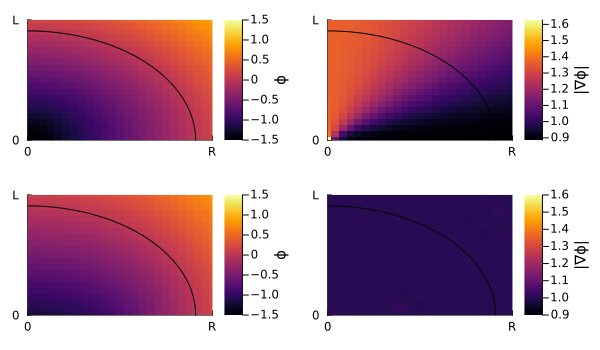

"c:\\Users\\iwheeler\\Documents\\LyoResearch\\LevelSetSublimation\\plots\\reinit_beforeafter.svg"

In [115]:
dom = Domain(25, 21, 2.0, 1.3)
ϕa = make_ϕ0(:circ, dom)
pl1 = heat(ϕa, dom)
plot!(LevelSet(ϕa, dom))
plot!(pl1, cbar_title="ϕ", clims=(-1.5,1.5))
plot!(xticks=((0, dom.rmax), ["0", "R"]), yticks=((0, dom.zmax), ("0", "L")))
pl2 = heat(𝒢_weno_all(ϕa, dom), dom)
plot!(LevelSet(ϕa, dom))
plot!(pl2, cbar_title="|∇ϕ|")
plot!(xticks=((0, dom.rmax), ["0", "R"]), yticks=((0, dom.zmax), ("0", "L")))
plot(pl1, pl2, layout=(2,1), size=(400,500))
savefig(plotsdir("pre_reinit.svg"))

ϕar = reinitialize_ϕ_HCR(ϕa, dom, maxsteps=200)
pl3 = heat(ϕar, dom)
plot!(LevelSet(ϕar, dom))
plot!(pl3, cbar_title="ϕ", clims=(-1.5, 1.5))
plot!(xticks=((0, dom.rmax), ["0", "R"]), yticks=((0, dom.zmax), ("0", "L")))
pl4 = heat(𝒢_weno_all(ϕar, dom), dom)
plot!(LevelSet(ϕar, dom))
plot!(pl4, cbar_title="|∇ϕ|", clims=(0.9, 1.6))
plot!(xticks=((0, dom.rmax), ["0", "R"]), yticks=((0, dom.zmax), ("0", "L")))

plot(pl1, pl2, pl3, pl4)
pl_all = plot(pl1, pl2, pl3, pl4, size=(600, 350))
display(pl_all)
savefig(plotsdir("reinit_beforeafter.svg"))


## Velocity Extension
Use the heat-only version, for more interesting results

In [90]:
controls = Dict{Symbol, Any}(
    :t_samp => 0.0u"s",
    :Tsh => 253.15u"K",
    :QRFf => 1u"W/cm^3"
)
cparams = make_default_params()
config = Dict(
    :ϕ0type => :circ,
    :fillvol => 2u"mL",
    :vialsize => "6R",
    :simgridsize => (25, 21),
    :Tf0 => 243.15u"K",
    :controls => controls,
    :cparams => cparams,
)
params, meas_keys, ncontrols = params_nondim_setup(cparams, controls)
;

In [91]:
@unpack cparams, ϕ0type, Tf0, controls, vialsize, fillvol = config

Tvw0 = get(config, :Tvw0, Tf0) # Default to same ice & glass temperature if glass initial not given
simgridsize = get(config, :simgridsize, (51,51))

# --------- Set up simulation domain
r_vial = get_vial_rad(vialsize)
z_fill = fillvol / π / r_vial^2

rmax = ustrip(u"m", r_vial)
zmax = ustrip(u"m", z_fill)

dom = Domain(simgridsize..., rmax, zmax)

# ----- Nondimensionalize everything

Tf0 = ustrip(u"K", Tf0)
Tvw0 = ustrip(u"K", Tvw0)
params, meas_keys, ncontrols = params_nondim_setup(cparams, controls) # Covers the various physical parameters 

ϕ0 = make_ϕ0(ϕ0type, dom)
# Make sure that the starting profile is very well-initialized
# The chosen tolerance is designed to the error almost always seen in norm of the gradient
reinitialize_ϕ_HCR!(ϕ0, dom, maxsteps=500, tol=1.2/max(dom.nr,dom.nz), err_reg=:all) 

ϕ0_flat = reshape(ϕ0, :)


# Full array of starting state variables ------------
u = similar(ϕ0_flat, ulen(dom)) # Add 2 to length: Tf, Tvw
u[iϕ(dom)] .= ϕ0_flat
u[iTf(dom)] = Tf0 
u[iTvw(dom)] = Tvw0 
# @info "Initial Tf:" Tf0 p_sub
;

In [92]:
T = solve_T(u, dom, params)

vf, dϕdx_all = compute_frontvel_heat(u, T, dom, params)
vf_pre = copy(vf)
vr_pre = vf[:,:,1]
vz_pre = vf[:,:,2]
extrap_v_fastmarch!(vf, u, dom)
vr = @view vf[:,:,1]
vz = @view vf[:,:,2]

25×21 view(::Array{Float64, 3}, :, :, 2) with eltype Float64:
 -1.11939e-6  -1.11939e-6  -1.11939e-6  …  -1.1194e-6   -1.1194e-6
 -1.11839e-6  -1.11849e-6  -1.11858e-6     -1.1194e-6   -1.1194e-6
 -1.11415e-6  -1.11453e-6  -1.11487e-6     -1.11776e-6  -1.11786e-6
 -1.10704e-6  -1.10796e-6  -1.10878e-6     -1.11554e-6  -1.1157e-6
 -1.09674e-6  -1.09855e-6  -1.1001e-6      -1.11208e-6  -1.11242e-6
 -1.08237e-6  -1.08553e-6  -1.08823e-6  …  -1.1078e-6   -1.1083e-6
 -1.06318e-6  -1.06808e-6  -1.0724e-6      -1.10255e-6  -1.10329e-6
 -1.03833e-6  -1.04527e-6  -1.05195e-6     -1.09655e-6  -1.09752e-6
 -1.00421e-6  -1.01562e-6  -1.02605e-6     -1.0893e-6   -1.09067e-6
 -9.48065e-7  -9.75924e-7  -9.9293e-7      -1.08075e-6  -1.08258e-6
  ⋮                                     ⋱                ⋮
 -5.27047e-8  -2.66974e-7  -4.48118e-7     -9.88204e-7  -9.94944e-7
 -5.46671e-8  -2.02246e-7  -3.75726e-7     -9.71074e-7  -9.78466e-7
 -5.59286e-8  -1.54663e-7  -3.19524e-7     -9.52957e-7  -9.61335e-7

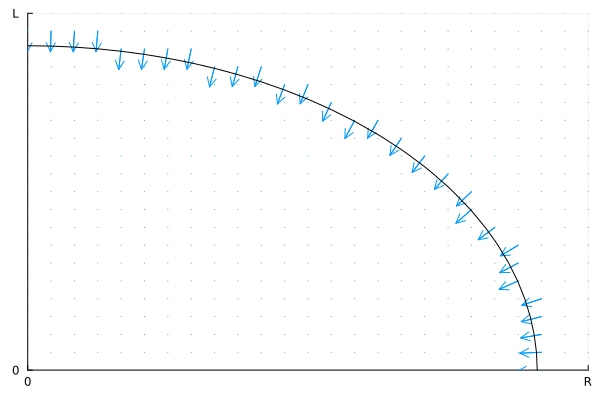

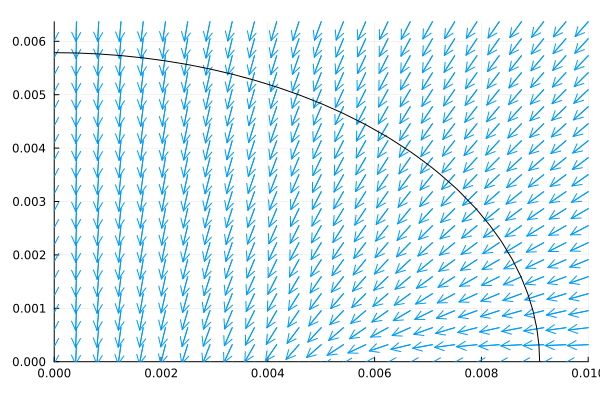

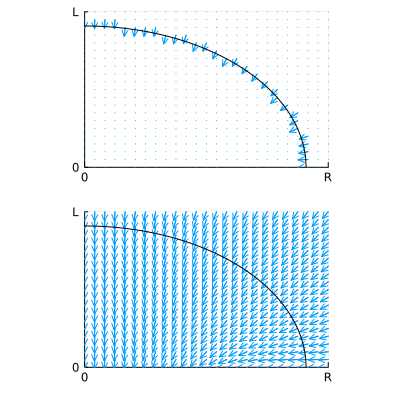

"c:\\Users\\iwheeler\\Documents\\LyoResearch\\LevelSetSublimation\\plots\\velocity_extension.svg"

In [109]:
maxv = sqrt(maximum(sum(vf_pre.^2, dims=(1,2))))
domsize = min(dom.rmax, dom.zmax)
pl5 = freshplot(dom)
arrows(vf_pre ./ maxv * domsize/4 , dom)
plot!(LevelSet(ϕ0, dom))
plot!(xticks=((0, dom.rmax), ["0", "R"]), yticks=((0, dom.zmax), ("0", "L")))
display(pl5)

pl6 = freshplot(dom)
arrows(vf ./ maxv * domsize/4, dom)
plot!(LevelSet(ϕ0, dom))
display(pl6)
plot!(xticks=((0, dom.rmax), ["0", "R"]), yticks=((0, dom.zmax), ("0", "L")))

display(plot(pl5, pl6, layout=(2,1), size=(400,400)))
savefig(plotsdir("velocity_extension.svg"))

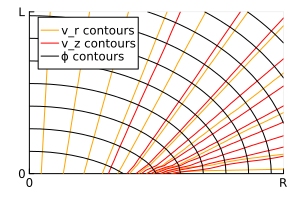

"c:\\Users\\iwheeler\\Documents\\LyoResearch\\LevelSetSublimation\\plots\\phi_v_contours.svg"

In [114]:
pl7 = freshplot(dom)
vr_scaled = vr / (maximum(vr) - minimum(vr))
vz_scaled = vz / (maximum(vz) - minimum(vz))
ϕ_scaled = ϕ0 / (maximum(ϕ0) - minimum(ϕ0))
colors = [:orange, :red, :black]
Plots.contour!(dom.rgrid, dom.zgrid, vr_scaled', c=colors[1], cbar=:none, label="v_r contours")
Plots.contour!(dom.rgrid, dom.zgrid, vz_scaled', c=colors[2],  cbar=:none)
Plots.contour!(dom.rgrid, dom.zgrid, ϕ_scaled' , c=colors[3],  cbar=:none, label="ϕ contours")

plot!([-1], [-1 -1 -1], labels=permutedims(["v_r", "v_z", "ϕ"]).*" contours", c=permutedims(colors))
plot!(xlims=(0,dom.rmax), ylims=(0,dom.zmax))
plot!(size=(300, 200))
plot!(xticks=((0, dom.rmax), ["0", "R"]), yticks=((0, dom.zmax), ("0", "L")))
display(pl7)
savefig(plotsdir("phi_v_contours.svg"))